# Imports

In [1]:
from ast import literal_eval
import functools
import json
import os
import random
import shutil
import pdb

# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import datasets
from torch import cuda
torch.set_grad_enabled(False)
from tqdm  import tqdm 

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook",
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities

from general_utils import (
  ModelAndTokenizer,
  make_inputs,
  decode_tokens,
  find_token_range,
  predict_from_input,
)

from patchscopes_utils import *

from tqdm import tqdm
tqdm.pandas()

In [2]:
model_to_hook = {
    "/data3/MODELS/pythia-6.9b": set_hs_patch_hooks_neox,
    "EleutherAI/pythia-12b": set_hs_patch_hooks_neox,
    "/data3/MODELS/llama2-hf/llama-2-13b": set_hs_patch_hooks_llama_batch,
    "lmsys/vicuna-7b-v1.5": set_hs_patch_hooks_llama,
    "./stable-vicuna-13b": set_hs_patch_hooks_llama,
    "CarperAI/stable-vicuna-13b-delta": set_hs_patch_hooks_llama,
    "/data3/MODELS/gpt-j-6b": set_hs_patch_hooks_gptj_batch,
    "/data3/MODELS/Meta-Llama-3-8B-Instruct":set_hs_patch_hooks_llama_batch,
    "/data3/MODELS/llama2-hf/llama-2-13b-chat":set_hs_patch_hooks_llama_batch
}

In [3]:
# Load model

# 0-shot with GPT-J
model_name = "/data3/MODELS/gpt-j-6b"
# model_name = "/data3/MODELS/Meta-Llama-3-8B-Instruct"
sos_tok = False
if "13b" in model_name or "12b" in model_name:
    torch_dtype = torch.float16
else:
    torch_dtype = None

my_device = torch.device("cuda:4")
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=torch_dtype,
    device=my_device,
)
mt.set_hs_patch_hooks = model_to_hook[model_name]
mt.model.eval()
print(mt.num_layers)

/home/tsq/anaconda3/envs/EasyEdit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


28


In [4]:
def run_experiment(task_type, task_name, data_dir, output_dir, batch_size=512, n_samples=-1,
                   save_output=True, replace=False, only_correct=False, is_icl=True):
    fdir_out = f"{output_dir}/{task_type}"
    fname_out = f"{fdir_out}/{task_name}_only_correct_{only_correct}.pkl"
    if not replace and os.path.exists(fname_out):
        print(f"File {fname_out} exists. Skipping...")
        return
    print(f"Running experiment on {task_type}/{task_name}...")
    df = pd.read_pickle(f"{data_dir}/{task_type}/{task_name}.pkl")

    if only_correct:
        df = df[df["is_correct_baseline"]].reset_index(drop=True)
    # Dropping empty prompt sources. This is an artifact of saving and reloading inputs
    df = df[~df["prompt_source"].apply(lambda x: isinstance(x, float))].reset_index(drop=True)
    # Dropping prompt sources with \n. pandas read_pickle is not able to handle them properly and drops the rest of the input.
    df = df[~df["prompt_source"].str.contains('\n')].reset_index(drop=True)
    # After manual inspection, this example seems to have tokenization issues. 0Dropping.
    if task_name == "star_constellation":
        df = df[~df["prompt_source"].str.contains("service")].reset_index(drop=True)
    elif task_name == "object_superclass":
        df = df[~df["prompt_source"].str.contains("Swainson ’ s hawk and the prairie")].reset_index(drop=True)
    
    def tokenize_and_count(text):
        encoding = mt.tokenizer.tokenize(text)
        return len(encoding)
    df['token_count'] = df['prompt_source'].apply(tokenize_and_count)
    df = df[df['token_count'] > df['position_source']].reset_index(drop=True)
    print(f"\tNumber of samples: {len(df)}")

    # BATCHED
    batch = []
    for _, row in tqdm(df.iterrows()):
        for layer_source in range(mt.num_layers-1):
            for layer_target in range(mt.num_layers-1):
                item = dict(row)
                item.update({
                    "layer_source": layer_source,
                    "layer_target": layer_target,
                })
                batch.append(item)
    experiment_df = pd.DataFrame.from_records(batch)# 将列表转换为DataFrame,即将列表中的字典转换为DataFrame的行
    
    if n_samples > 0 and n_samples<len(experiment_df):
        experiment_df = experiment_df.sample(n=n_samples, replace=False, random_state=42).reset_index(drop=True)# 抽样

    print(f"\tNumber of datapoints for patching experiment: {len(experiment_df)}")
    

    eval_results = evaluate_attriburte_exraction_batch(mt, experiment_df, batch_size=batch_size, is_icl=is_icl)
    
    # eval_results = evaluate_attriburte_exraction_batch_multi_patch(mt, experiment_df, batch_size=batch_size, is_icl=is_icl)

    results_df = experiment_df.head(len(eval_results["is_correct_patched"]))
    for key, value in eval_results.items():
        results_df[key] = list(value)

    if save_output:
        fdir_out = f"{output_dir}/{task_type}"
        if not os.path.exists(fdir_out):
            os.makedirs(fdir_out)
        results_df.to_csv(f"{fdir_out}/{task_name}_only_correct_{only_correct}.tsv", sep="\t")
        results_df.to_pickle(f"{fdir_out}/{task_name}_only_correct_{only_correct}.pkl")
        

    return results_df

In [5]:
# for task_type in ["commonsense"]:
#     for fname in tqdm(os.listdir(f"./find_useful_context_pkl/context_from_wiki/{task_type}")):
#         if fname.endswith('.pkl'):
#             task_name = fname[:-4]
#         else:
#             continue
#         print(f"Processing {fname}...")
#         run_experiment(task_type, task_name,
#                         data_dir="./find_useful_context_pkl/context_from_wiki",
#                         output_dir=f"./new_data_output/context_from_wiki",
#                         batch_size=512,
#                         is_icl=False,
#                         only_correct=False,
#                         replace=False,
#                         )

In [6]:
# for task_type in ["commonsense", "factual"]:
# for task_type in ["commonsense"]:
for task_type in ["factual"]:
    for fname in tqdm(os.listdir(f"./preprocessed_data/gpt-j/{task_type}")):
        if fname.endswith('.pkl'):
            task_name = fname[:-4]
        else:
            continue
        print(f"Processing {fname}...")
        run_experiment(task_type, task_name,
                        data_dir="./preprocessed_data/gpt-j",
                        output_dir=f"./original_result/llama3",
                        batch_size=512,
                        is_icl=False,
                        only_correct=False,
                        replace=False,
                        )

  0%|          | 0/11 [00:00<?, ?it/s]

Processing superhero_person.pkl...
Running experiment on factual/superhero_person...
	Number of samples: 372


372it [00:10, 36.33it/s]


	Number of datapoints for patching experiment: 357492


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


[128001, 128009]


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[128001, 128009]


  0%|          | 0/11 [00:24<?, ?it/s]


KeyboardInterrupt: 

## Plot
heatmaps conditional on correct base model prediciton

In [4]:
def plot_heatmap(fname, _vmin=0, _vmax=1):
    df = pd.read_pickle(fname)
    plot_ttl = f"{fname}\n{model_name.strip('./')}"
    pd.set_option('display.max_columns',1000)   # 设置最大显示列数的多少
    pd.set_option('display.width',1000)         # 设置宽度,就是说不换行,比较好看数据
    # 对于同一prompt_target和layer_source，如果is_correct_patch为True，则认为patch成功，计算patch成功率
    
    
    
    sub_df = df[df["is_correct_baseline"]].reset_index(drop=True)
    accuracy = np.mean(sub_df["is_correct_patched"])
    print (f"{fname} Accuracy: {accuracy}")
    heatmap_data_patched_given_correct_original = sub_df.groupby(['layer_source', 'layer_target'])["is_correct_patched"].mean().unstack()
    ax = sns.heatmap(data=heatmap_data_patched_given_correct_original, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl} - accuracy\n(successful patch conditional on SUCESSFUL original)")
    plt.show()
    plt.clf()
    

    sub_df_2 = df[df["is_correct_baseline"]==False].reset_index(drop=True)
    accuracy = np.mean(sub_df_2["is_correct_patched"])
    print (f"{fname} Accuracy: {accuracy}")
    heatmap_data_patched_given_incorrect_original = sub_df_2.groupby(['layer_source', 'layer_target'])["is_correct_patched"].mean().unstack()
    ax = sns.heatmap(data=heatmap_data_patched_given_incorrect_original, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl} - accuracy\n(successful patch conditional on UNSUCCESSFUL original)")
    plt.show()
    plt.clf()

    heatmap_data_original = df.groupby(['layer_source', 'layer_target'])["is_correct_baseline"].mean().unstack()
    accuracy = np.mean(df["is_correct_baseline"])
    print (f"{fname} Accuracy: {accuracy}")
    ax = sns.heatmap(data=heatmap_data_original, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl} - successful original")
    plt.show()
    plt.clf()

    heatmap_data_patched = df.groupby(['layer_source', 'layer_target'])["is_correct_patched"].mean().unstack()
    accuracy = np.mean(df["is_correct_patched"])
    print (f"{fname} Accuracy: {accuracy}")
    ax = sns.heatmap(data=heatmap_data_patched, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl} - successful patched")
    plt.show()

    # if "is_correct_probe" in df.columns:
    #     heatmap_probe_correct_original = sub_df.groupby(['layer_source', 'layer_target'])["is_correct_probe"].mean().unstack()
    #     ax = sns.heatmap(data=heatmap_data_patched_given_correct_original, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    #     ax.invert_yaxis()
    #     ax.set_title(f"{plot_ttl} - accuracy\n(probe success conditional on SUCESSFUL original)")
    #     plt.show()
    #     plt.clf()

    #     heatmap_probe_given_incorrect_original = sub_df_2.groupby(['layer_source', 'layer_target'])["is_correct_probe"].mean().unstack()
    #     ax = sns.heatmap(data=heatmap_probe_given_incorrect_original, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    #     ax.invert_yaxis()
    #     ax.set_title(f"{plot_ttl} - accuracy\n(probe success conditional on UNSUCCESSFUL original)")
    #     plt.show()
    #     plt.clf()

    #     heatmap_probe = df.groupby(['layer_source', 'layer_target'])["is_correct_probe"].mean().unstack()
    #     ax = sns.heatmap(data=heatmap_probe, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    #     ax.invert_yaxis()
    #     ax.set_title(f"{plot_ttl} - successful probe")
    #     plt.show()

./multi_patch_output/llama2/factual/superhero_person_only_correct_False.pkl Accuracy: 0.00185902844313518


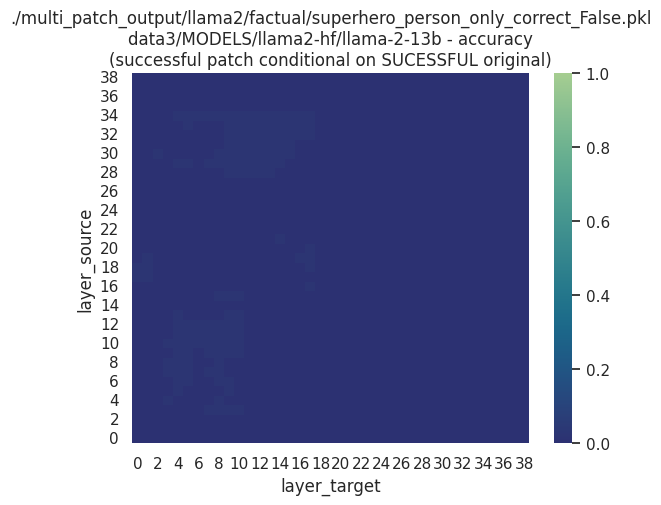

./multi_patch_output/llama2/factual/superhero_person_only_correct_False.pkl Accuracy: 2.010587755118454e-05


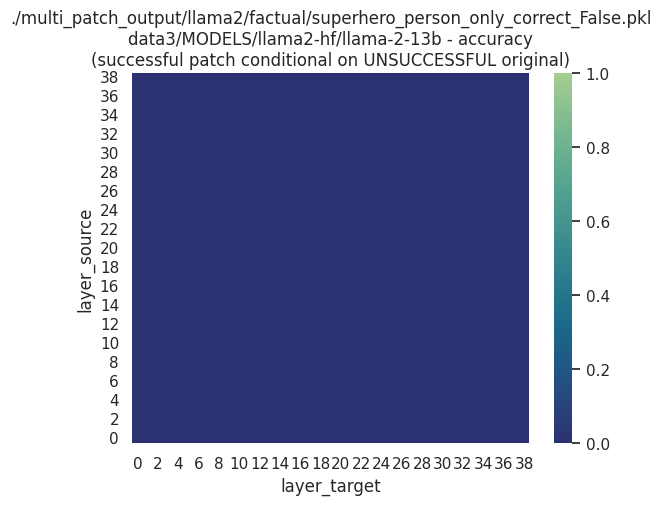

./multi_patch_output/llama2/factual/superhero_person_only_correct_False.pkl Accuracy: 0.12326721852436823


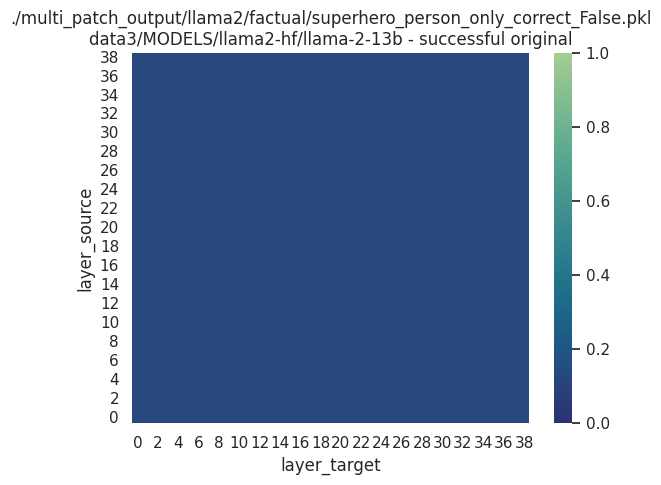

./multi_patch_output/llama2/factual/superhero_person_only_correct_False.pkl Accuracy: 0.00024678474729241876


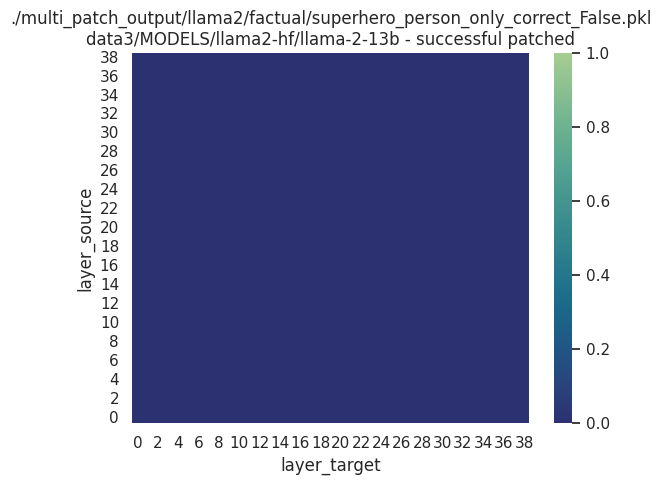

./multi_patch_output/llama2/factual/pokemon_evolutions_only_correct_False.pkl Accuracy: 0.0014464168310322155


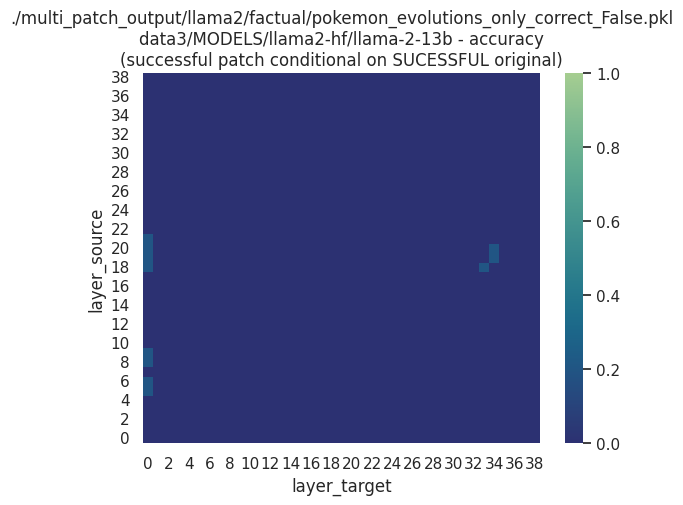

./multi_patch_output/llama2/factual/pokemon_evolutions_only_correct_False.pkl Accuracy: 0.00011403519886471624


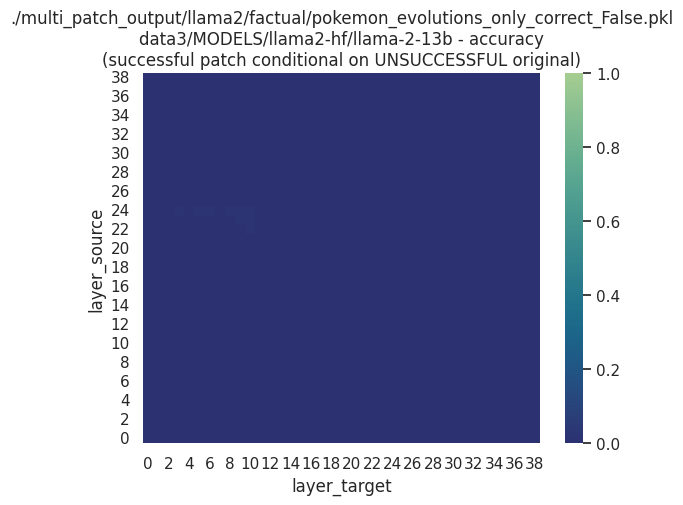

./multi_patch_output/llama2/factual/pokemon_evolutions_only_correct_False.pkl Accuracy: 0.087890625


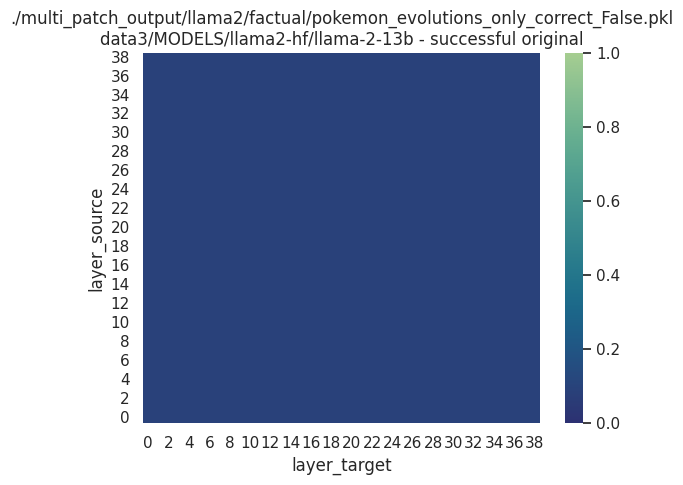

./multi_patch_output/llama2/factual/pokemon_evolutions_only_correct_False.pkl Accuracy: 0.00023113905325443786


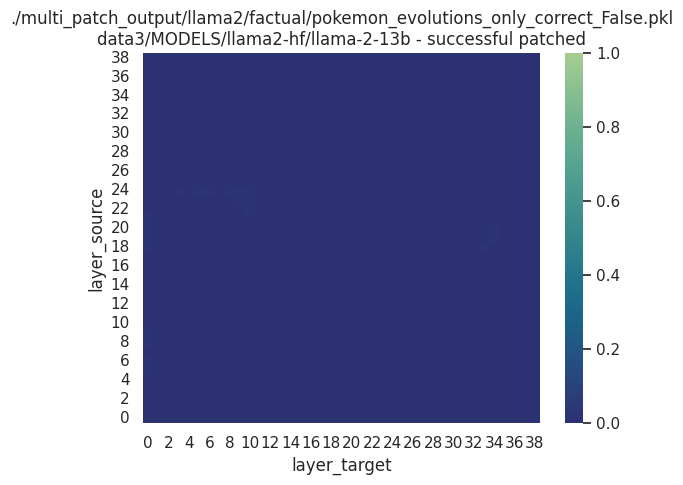

./multi_patch_output/llama2/factual/country_capital_city_only_correct_False.pkl Accuracy: 0.012501227673873697


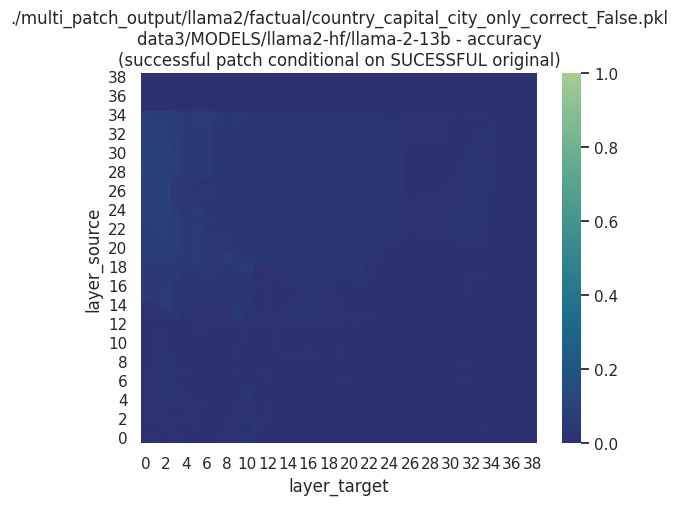

./multi_patch_output/llama2/factual/country_capital_city_only_correct_False.pkl Accuracy: 0.0010331548793087255


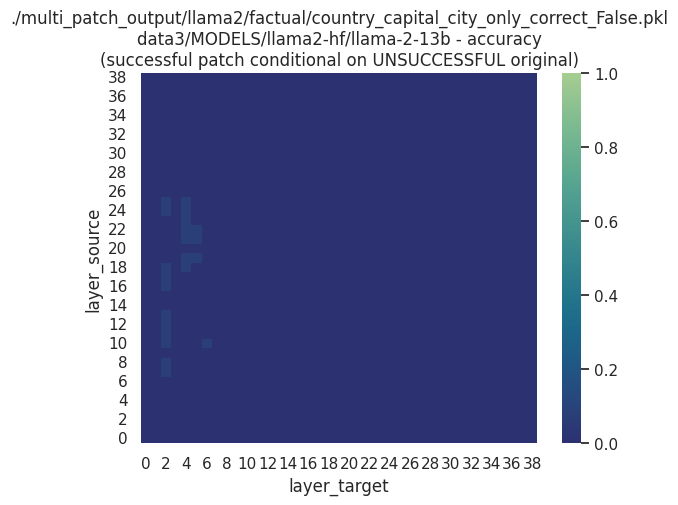

./multi_patch_output/llama2/factual/country_capital_city_only_correct_False.pkl Accuracy: 0.87003173828125


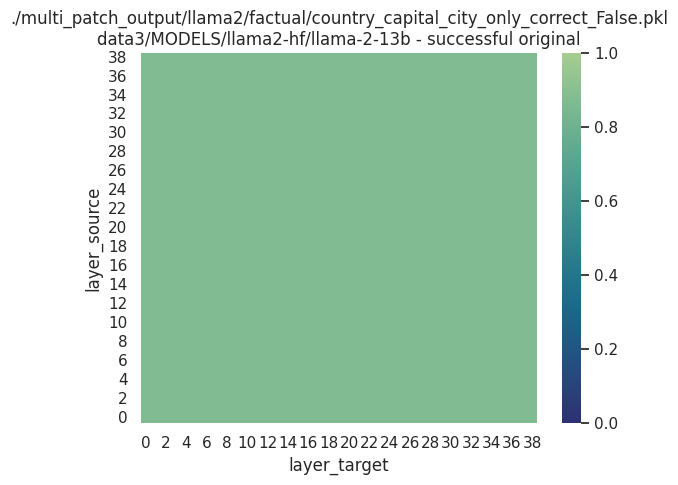

./multi_patch_output/llama2/factual/country_capital_city_only_correct_False.pkl Accuracy: 0.0110107421875


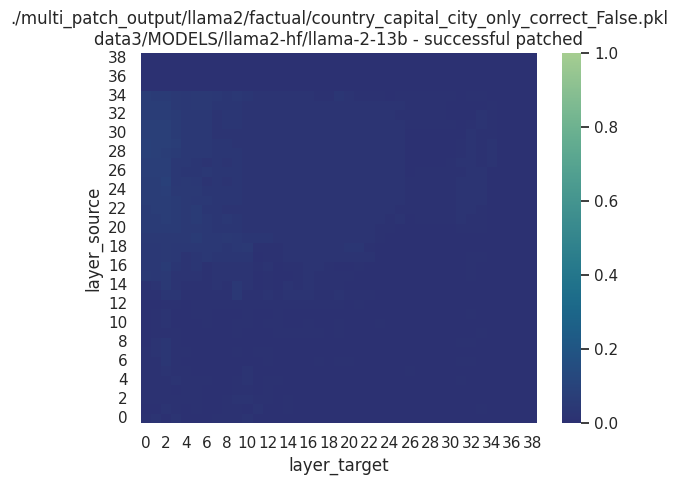

./multi_patch_output/llama2/factual/product_by_company_only_correct_False.pkl Accuracy: 0.06731525803743654


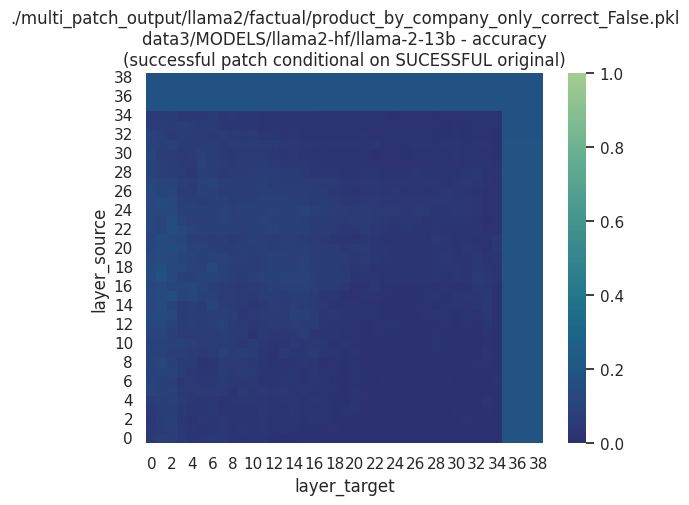

./multi_patch_output/llama2/factual/product_by_company_only_correct_False.pkl Accuracy: 0.07858949479165013


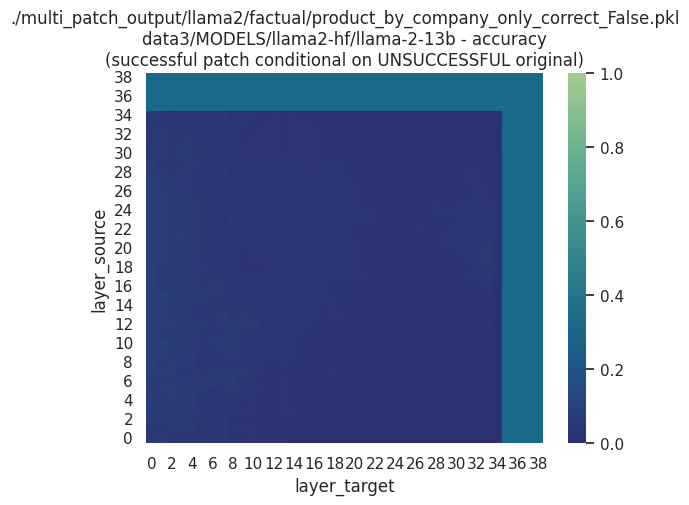

./multi_patch_output/llama2/factual/product_by_company_only_correct_False.pkl Accuracy: 0.2868934516331658


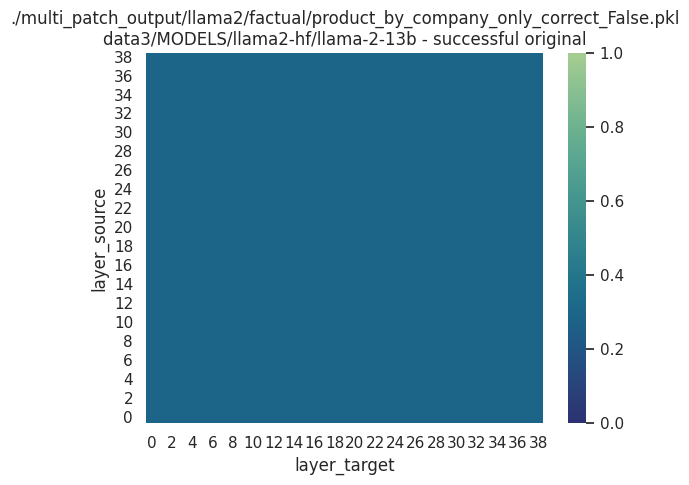

./multi_patch_output/llama2/factual/product_by_company_only_correct_False.pkl Accuracy: 0.0753549900947043


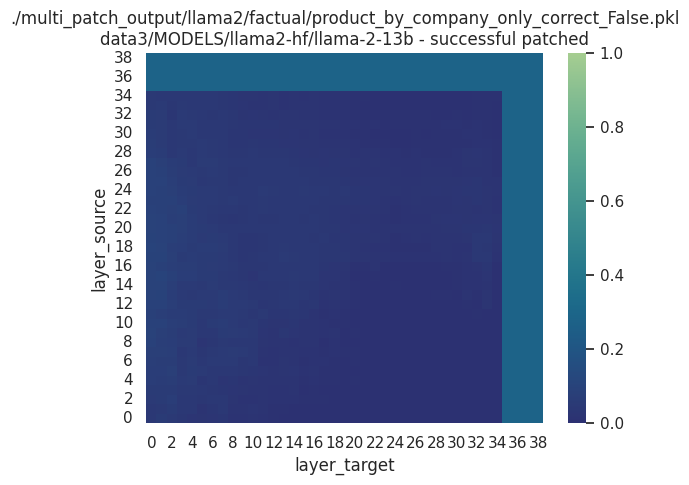

./multi_patch_output/llama2/factual/food_from_country_only_correct_False.pkl Accuracy: 0.011742940603700097


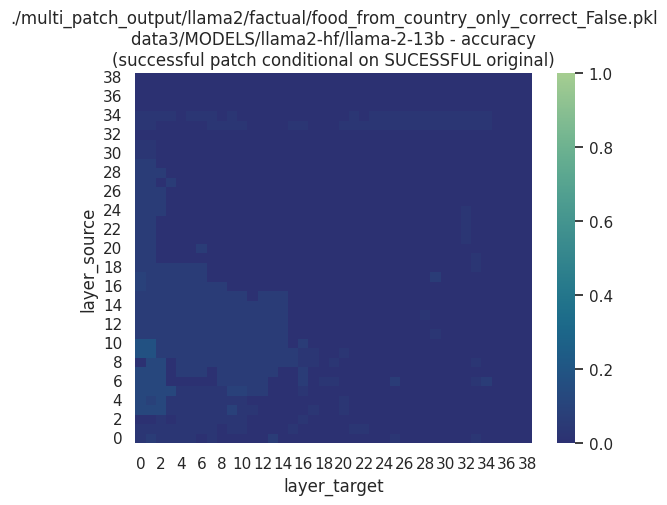

./multi_patch_output/llama2/factual/food_from_country_only_correct_False.pkl Accuracy: 0.0003944773175542406


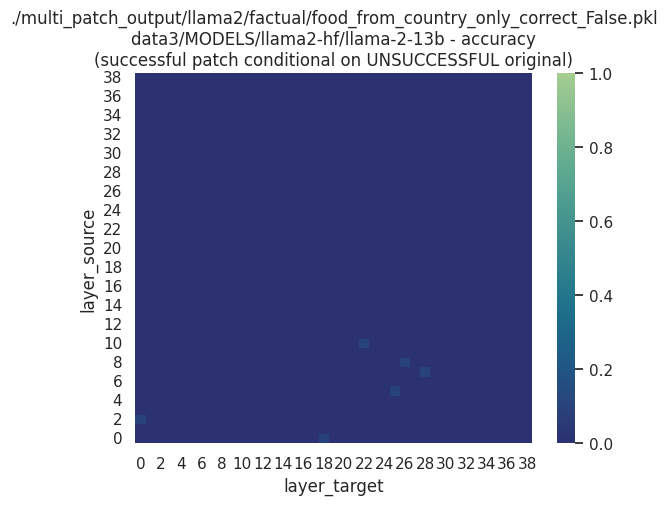

./multi_patch_output/llama2/factual/food_from_country_only_correct_False.pkl Accuracy: 0.771484375


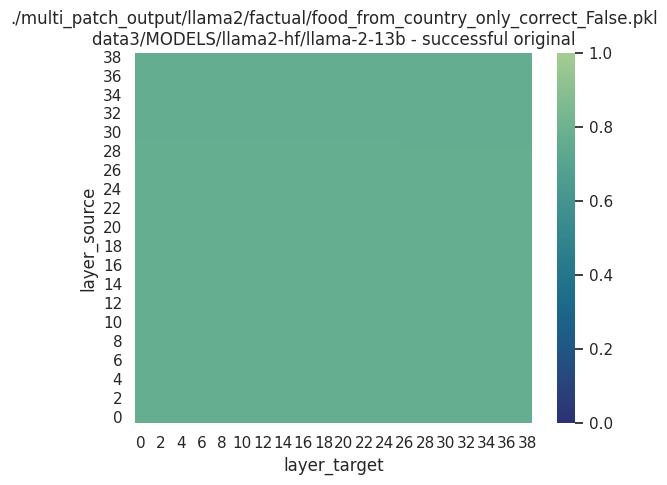

./multi_patch_output/llama2/factual/food_from_country_only_correct_False.pkl Accuracy: 0.009149639423076924


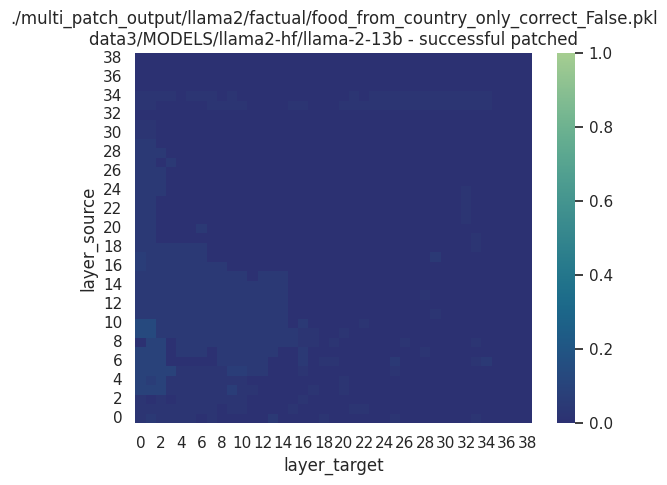

./multi_patch_output/llama2/factual/country_largest_city_only_correct_False.pkl Accuracy: 0.01719262116773501


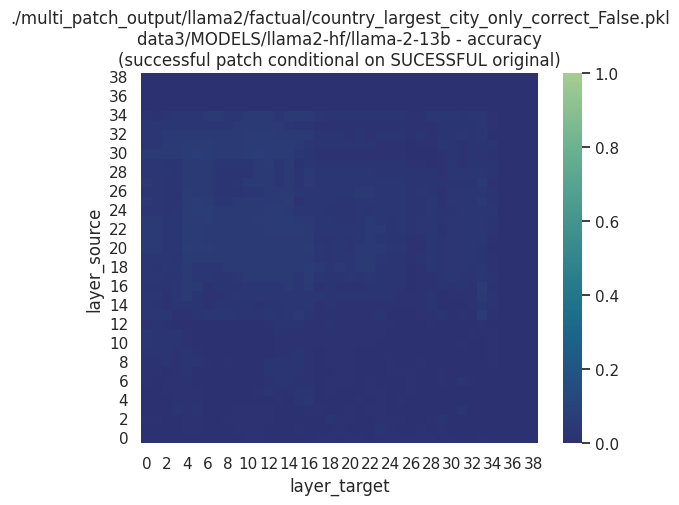

./multi_patch_output/llama2/factual/country_largest_city_only_correct_False.pkl Accuracy: 0.0774709620863467


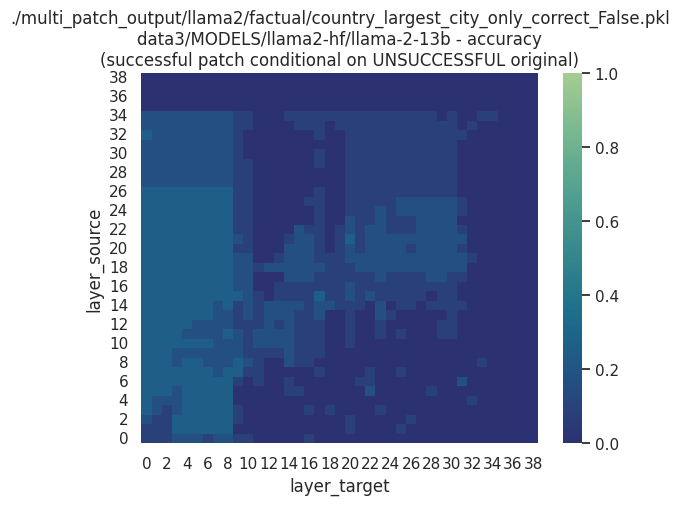

./multi_patch_output/llama2/factual/country_largest_city_only_correct_False.pkl Accuracy: 0.8831198770491804


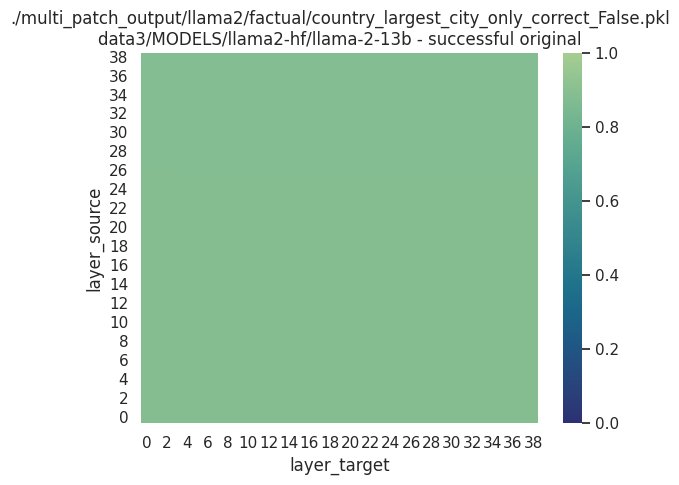

./multi_patch_output/llama2/factual/country_largest_city_only_correct_False.pkl Accuracy: 0.02423796106557377


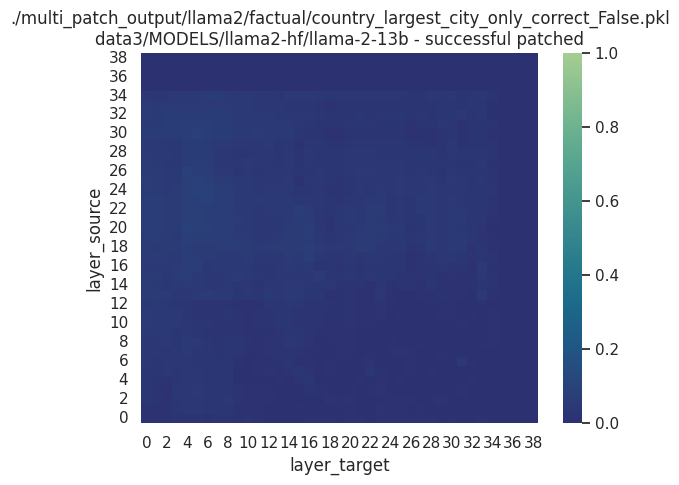

./multi_patch_output/llama2/factual/country_currency_only_correct_False.pkl Accuracy: 0.08600087221979939


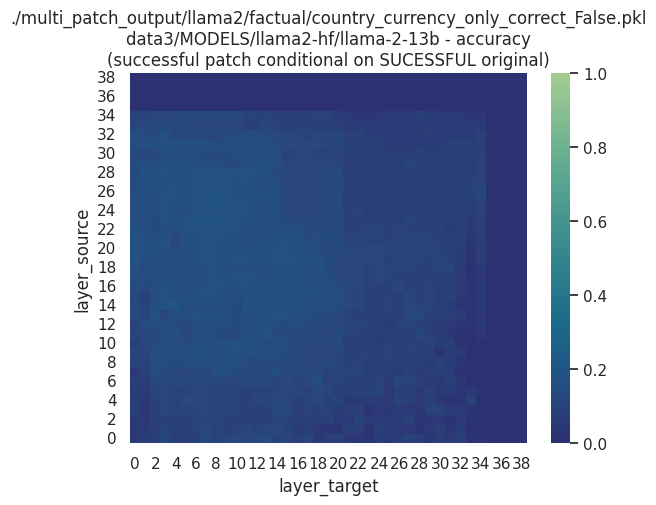

./multi_patch_output/llama2/factual/country_currency_only_correct_False.pkl Accuracy: 0.02973190152677332


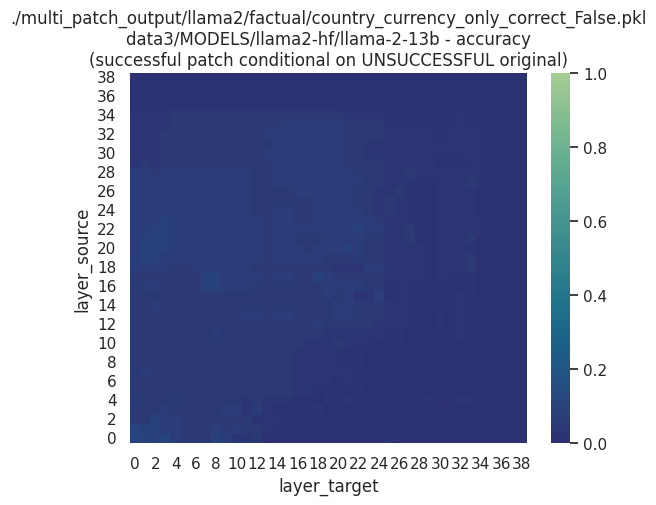

./multi_patch_output/llama2/factual/country_currency_only_correct_False.pkl Accuracy: 0.648206208881579


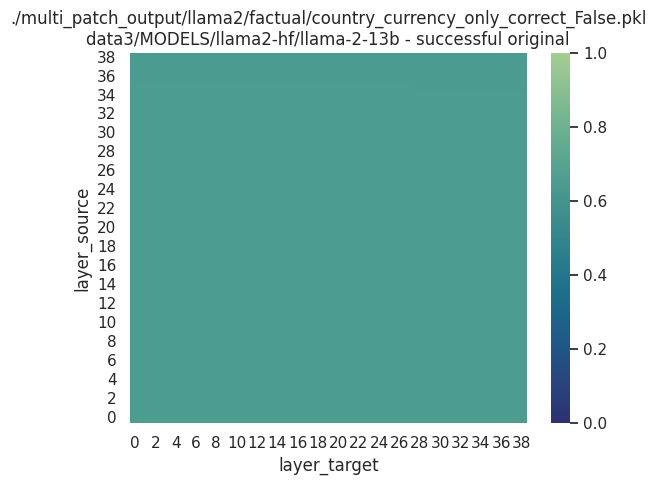

./multi_patch_output/llama2/factual/country_currency_only_correct_False.pkl Accuracy: 0.06620579769736842


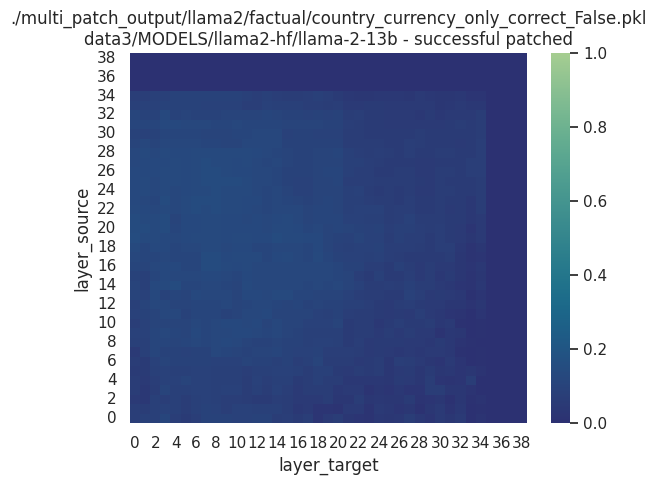

./multi_patch_output/llama2/factual/person_mother_only_correct_False.pkl Accuracy: 0.0


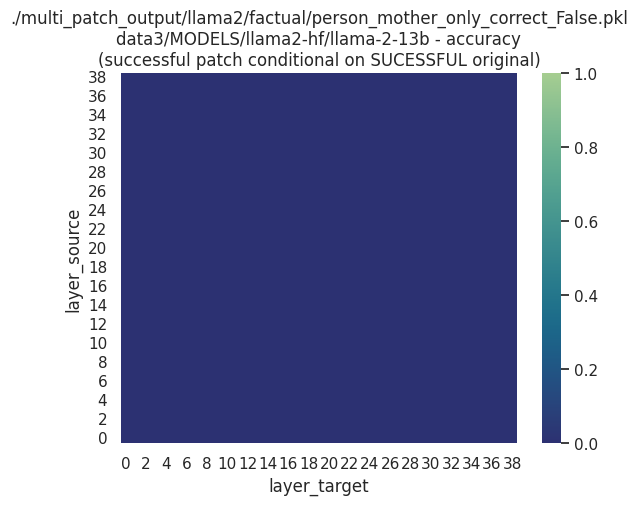

./multi_patch_output/llama2/factual/person_mother_only_correct_False.pkl Accuracy: 2.5461204437761532e-05


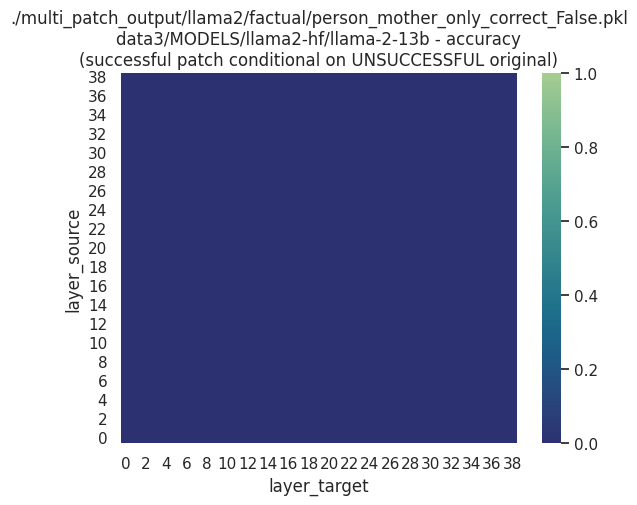

./multi_patch_output/llama2/factual/person_mother_only_correct_False.pkl Accuracy: 0.0008232895496535796


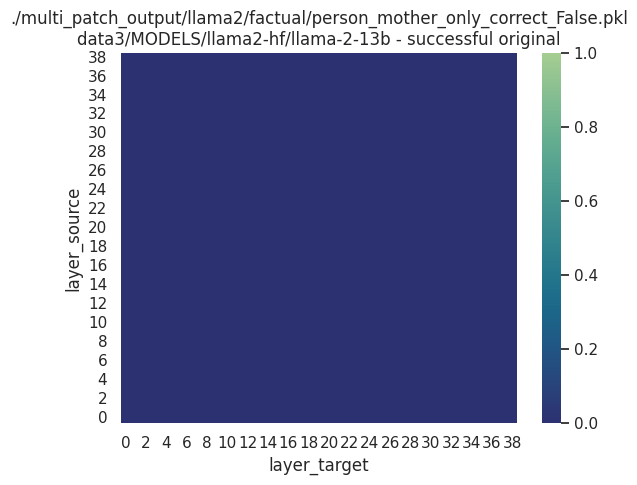

./multi_patch_output/llama2/factual/person_mother_only_correct_False.pkl Accuracy: 2.544024249422633e-05


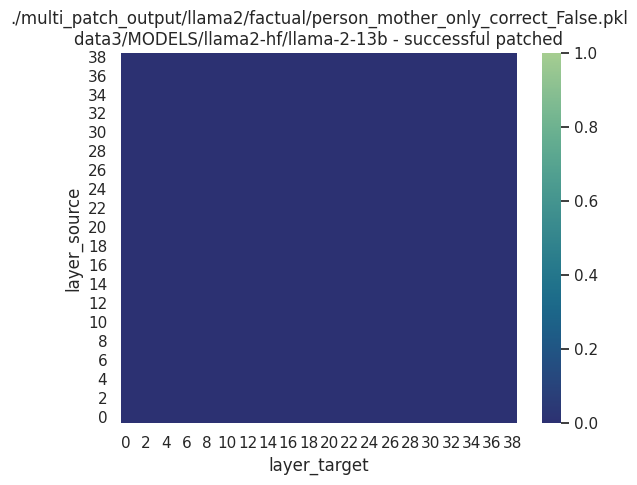

./multi_patch_output/llama2/factual/person_plays_position_in_sport_only_correct_False.pkl Accuracy: 0.04640205359930381


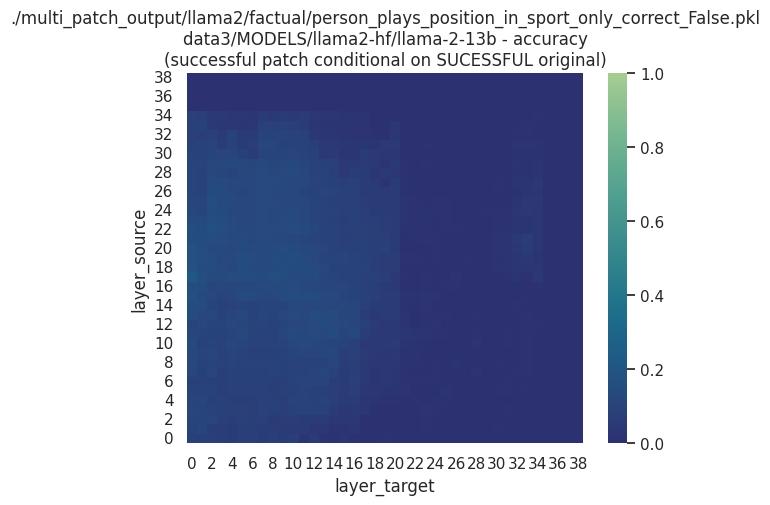

./multi_patch_output/llama2/factual/person_plays_position_in_sport_only_correct_False.pkl Accuracy: 0.01899359027898241


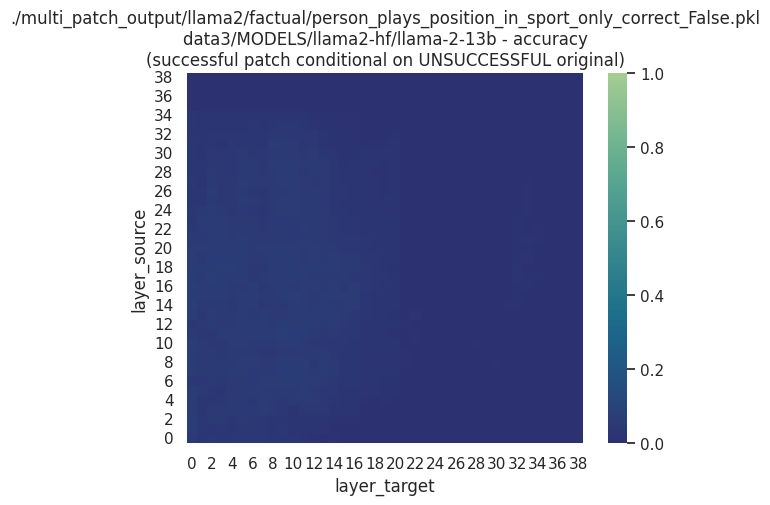

./multi_patch_output/llama2/factual/person_plays_position_in_sport_only_correct_False.pkl Accuracy: 0.32125587245720666


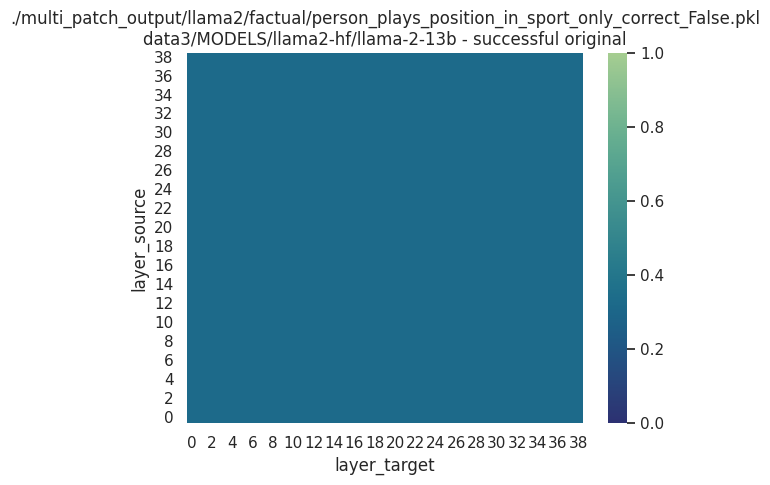

./multi_patch_output/llama2/factual/person_plays_position_in_sport_only_correct_False.pkl Accuracy: 0.027798720075663606


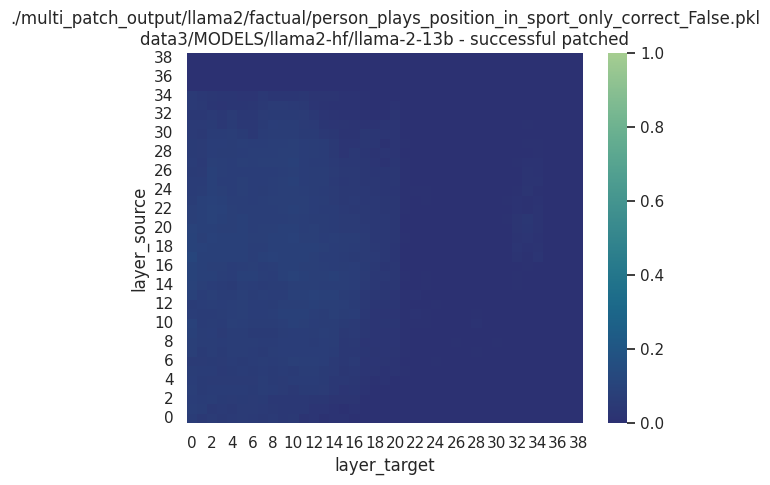

./multi_patch_output/llama2/factual/person_plays_pro_sport_only_correct_False.pkl Accuracy: 0.02463518039204772


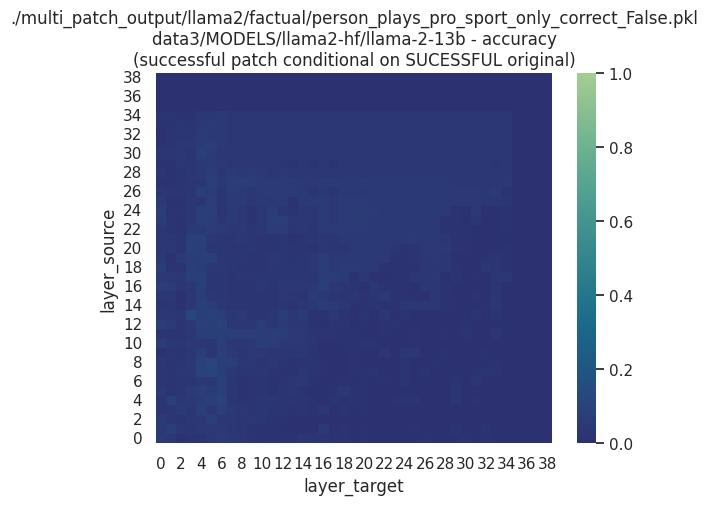

./multi_patch_output/llama2/factual/person_plays_pro_sport_only_correct_False.pkl Accuracy: 0.021459483720604647


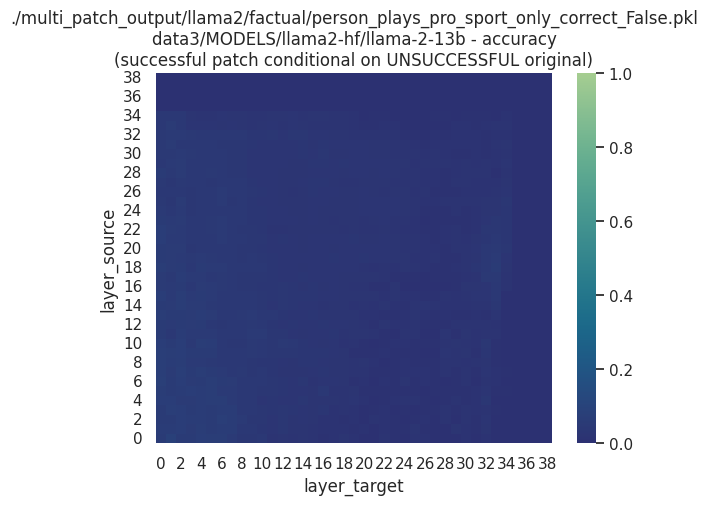

./multi_patch_output/llama2/factual/person_plays_pro_sport_only_correct_False.pkl Accuracy: 0.1288847279614325


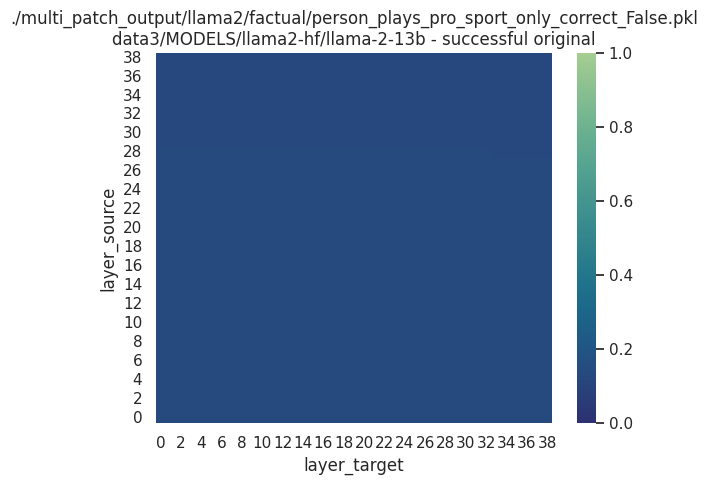

./multi_patch_output/llama2/factual/person_plays_pro_sport_only_correct_False.pkl Accuracy: 0.021868782522191613


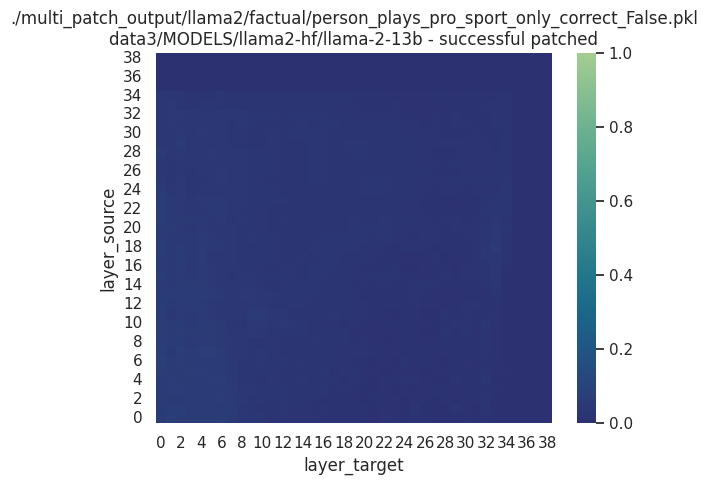

./multi_patch_output/llama2/factual/star_constellation_only_correct_False.pkl Accuracy: 0.028154227906088947


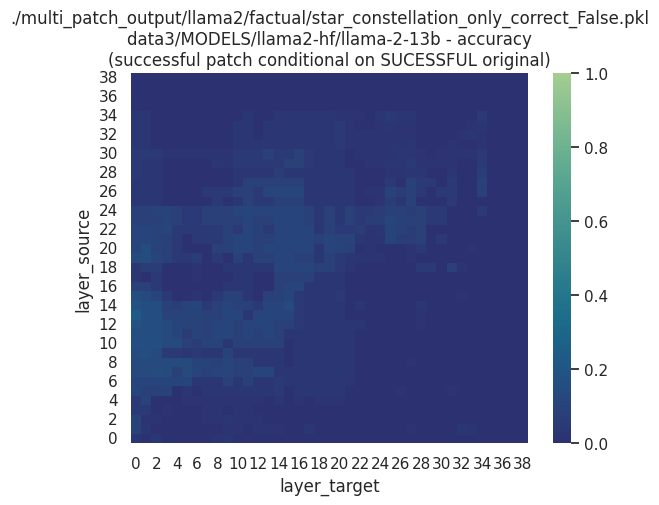

./multi_patch_output/llama2/factual/star_constellation_only_correct_False.pkl Accuracy: 0.009937921727395412


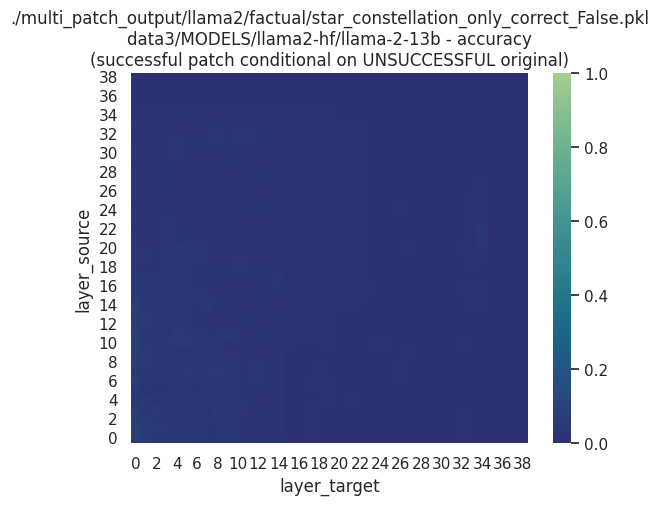

./multi_patch_output/llama2/factual/star_constellation_only_correct_False.pkl Accuracy: 0.3373325892857143


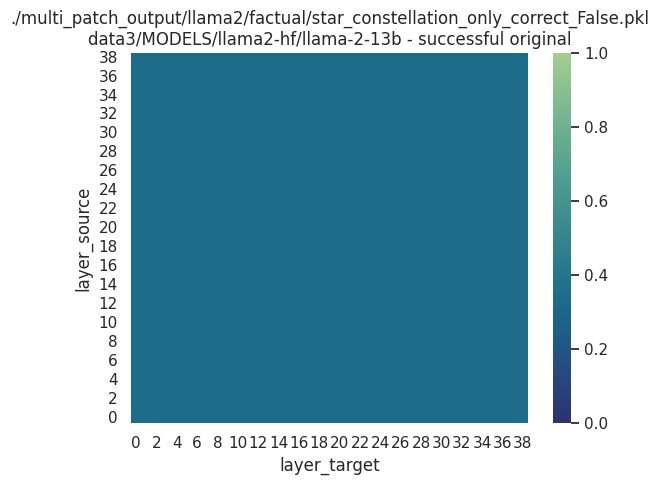

./multi_patch_output/llama2/factual/star_constellation_only_correct_False.pkl Accuracy: 0.016082875457875456


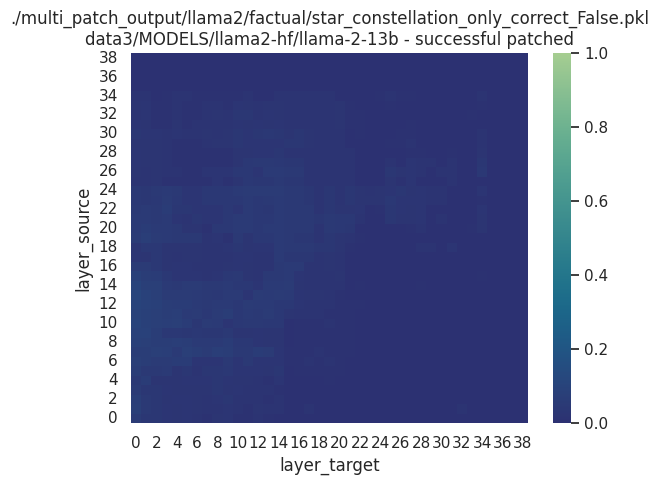

./multi_patch_output/llama2/factual/superhero_archnemesis_only_correct_False.pkl Accuracy: 0.007161641777026393


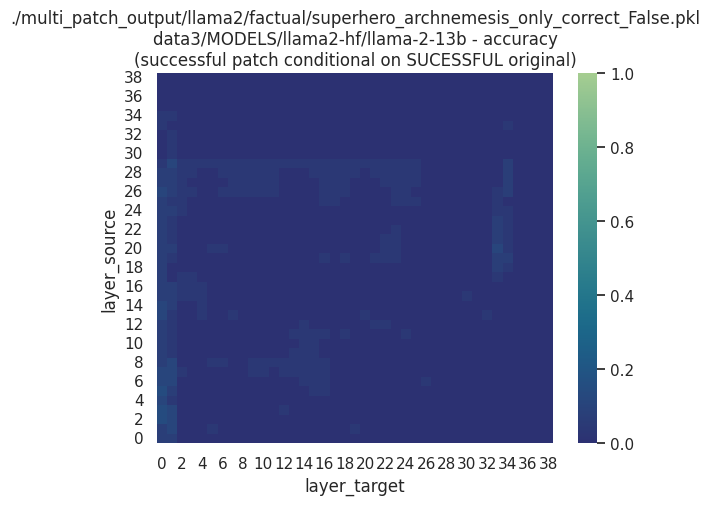

./multi_patch_output/llama2/factual/superhero_archnemesis_only_correct_False.pkl Accuracy: 0.0028475104960103345


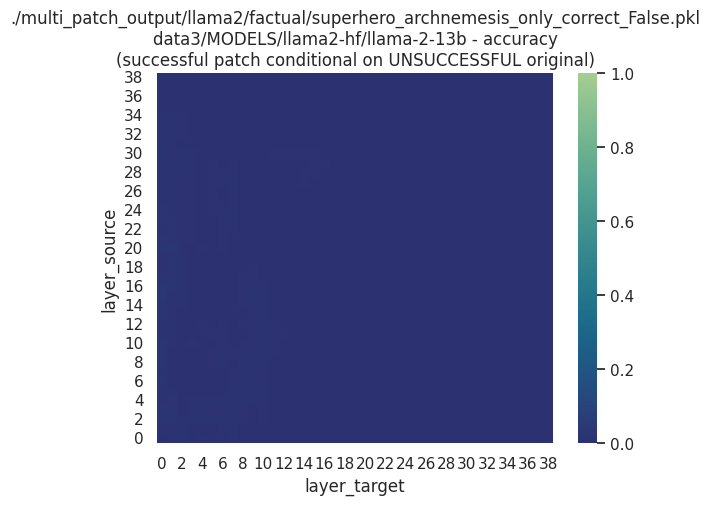

./multi_patch_output/llama2/factual/superhero_archnemesis_only_correct_False.pkl Accuracy: 0.07737645348837209


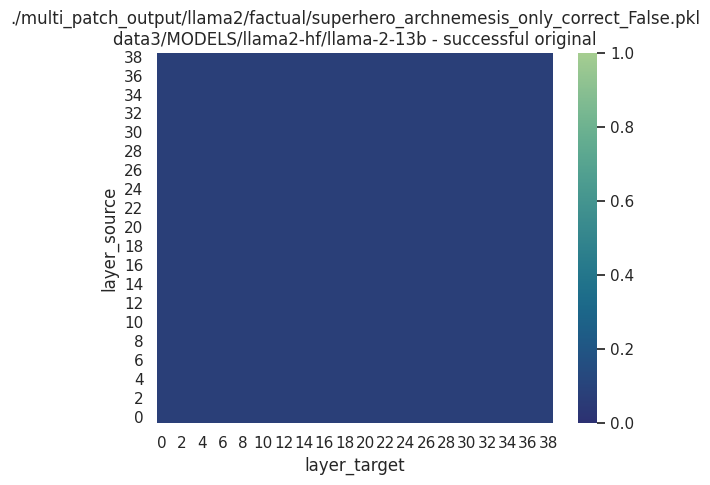

./multi_patch_output/llama2/factual/superhero_archnemesis_only_correct_False.pkl Accuracy: 0.0031813226744186046


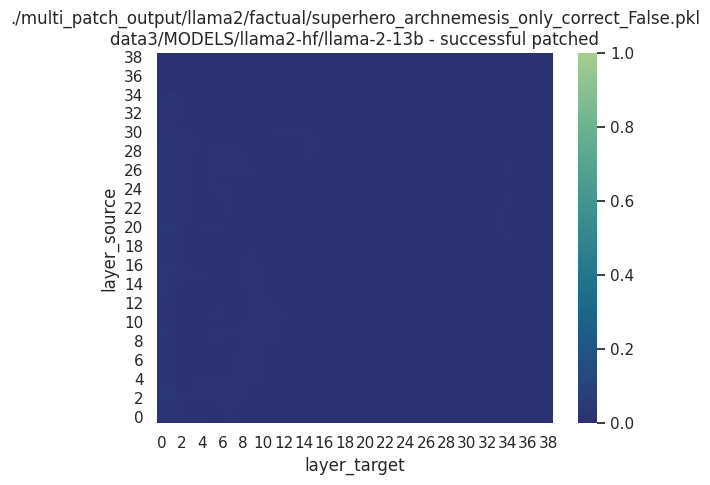

./multi_patch_output/llama2/factual/person_father_only_correct_False.pkl Accuracy: 0.0030152576571674714


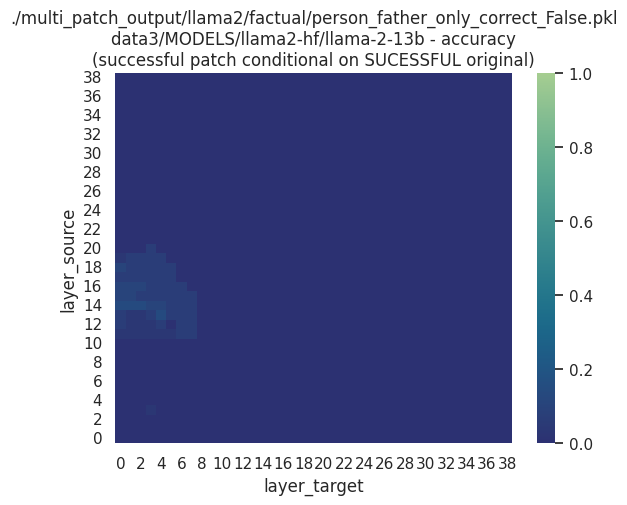

./multi_patch_output/llama2/factual/person_father_only_correct_False.pkl Accuracy: 0.0001633285837280598


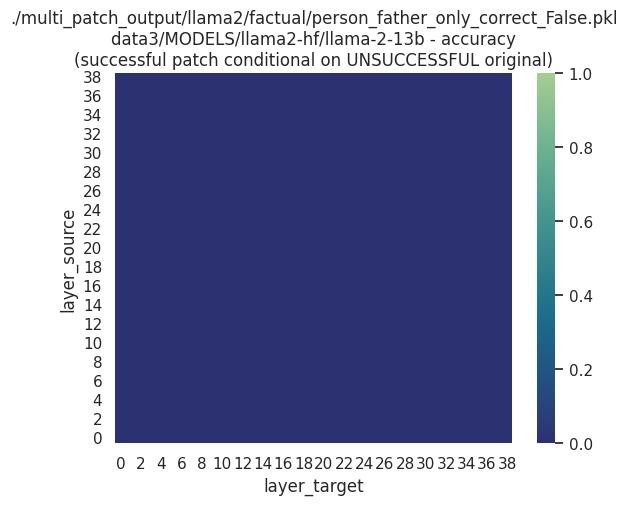

./multi_patch_output/llama2/factual/person_father_only_correct_False.pkl Accuracy: 0.008250372593851753


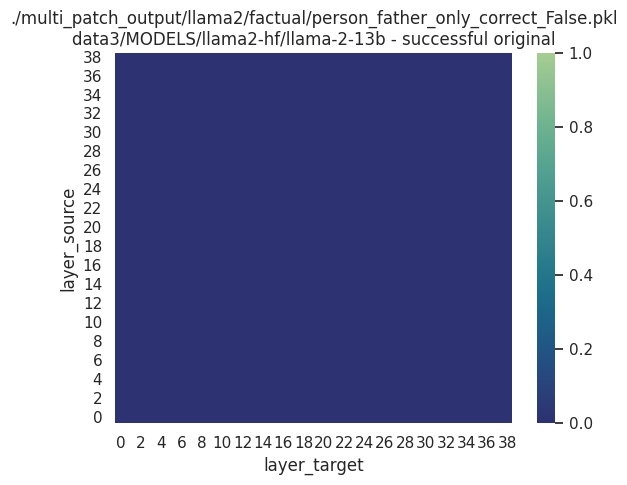

./multi_patch_output/llama2/factual/person_father_only_correct_False.pkl Accuracy: 0.00018685806119517334


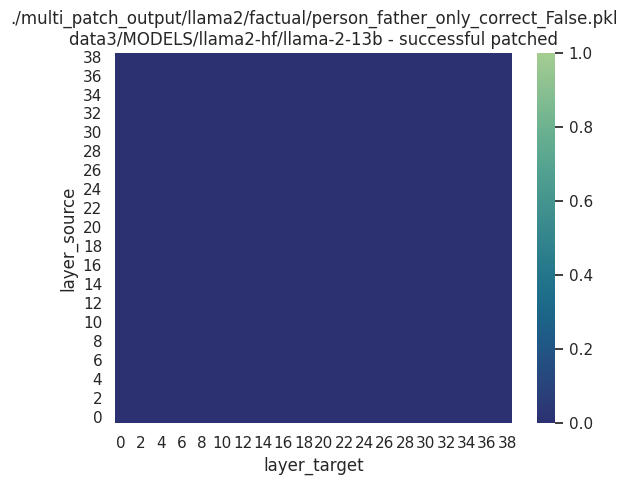

./multi_patch_output/llama2/factual/company_ceo_only_correct_False.pkl Accuracy: 0.02370585389453314


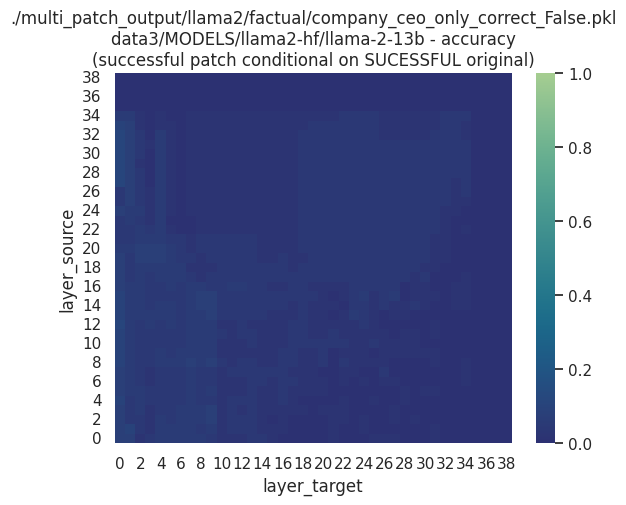

./multi_patch_output/llama2/factual/company_ceo_only_correct_False.pkl Accuracy: 0.002681065644789046


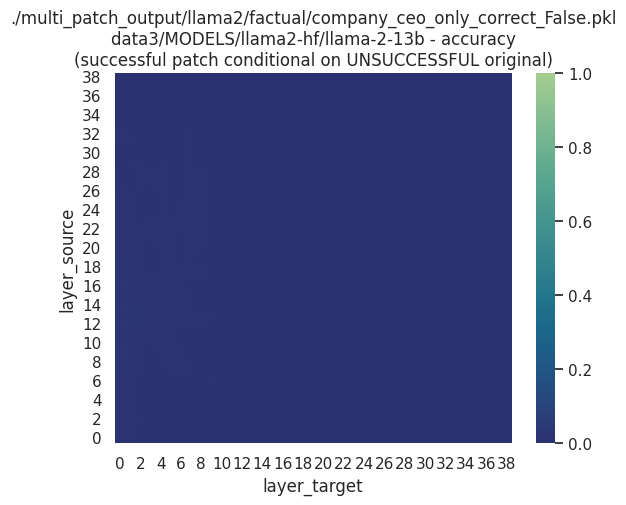

./multi_patch_output/llama2/factual/company_ceo_only_correct_False.pkl Accuracy: 0.06426419005102041


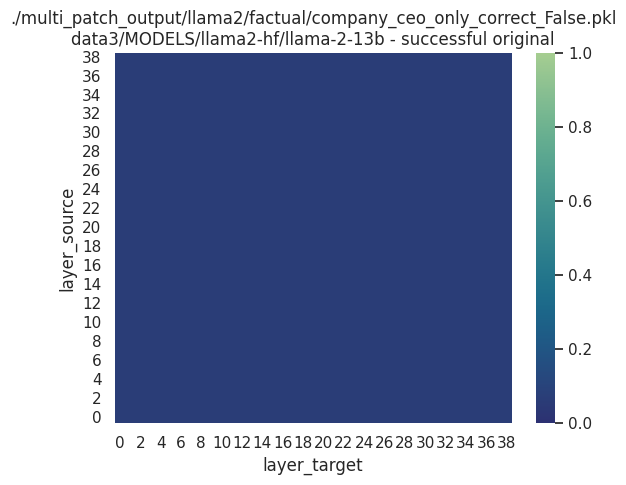

./multi_patch_output/llama2/factual/company_ceo_only_correct_False.pkl Accuracy: 0.004032206632653061


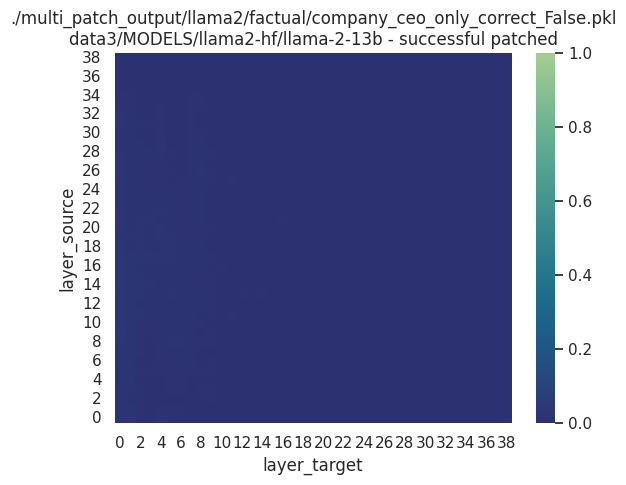

In [5]:
input_dir = "./original_result/gpt-j/factual"
input_dir = "./multi_patch_output/llama2/factual"
for fname in os.listdir(input_dir):
    if fname.endswith('.pkl'):
        plot_heatmap(f"{input_dir}/{fname}", _vmin=0, _vmax=1)
    else:
        continue

**Exp 0: Linguistic.**
Using the source with a prompt id as target.

**Exp 1: Linguistic.**
Using the source and target that are just parapharases of each other, but similar semantically.

**Exp 2: Commonsense.**
Sampling source prompts.

**Exp 3: Factual.**
Combining different tasks to make multihop reasoning.
Range of source should be the same as domain of target.

In [ ]:
def run_experiment(task_type, task_name, batch_size=512, n_samples=-1, save_output=True):
    print(f"Running experiment on {task_type}/{task_name}...")
    df = pd.read_pickle(f"./outputs/preprocessed_data/{task_type}/{task_name}.pkl")# Load data
    filtered_df = df[df["target_baseline_target"] == df["target_baseline_prediction_gpt-j-6B"]]# Filter data，即只保留预测正确的数据
    print(f"\tNumber of filtered samples: {len(filtered_df)}")

    # BATCHED
    batch = []
    for layer_source in tqdm.tqdm(range(mt.num_layers)):
        for layer_target in range(mt.num_layers):
            for _, row in filtered_df.iterrows():# iterrows是一个生成器，每次迭代返回一个元组，元组的第一个元素是行索引，第二个元素是行数据
                item = dict(row)# 将行数据转换为字典
                item.update({
                    "layer_source": layer_source,
                    "layer_target": layer_target,
                })# 更新字典，添加键值对
                batch.append(item)# 将字典添加到列表中
    experiment_df = pd.DataFrame.from_records(batch)# 将列表转换为DataFrame

    if n_samples > 0 and n_samples<len(experiment_df):
        experiment_df = experiment_df.sample(n=n_samples, replace=False, random_state=42).reset_index(drop=True)

    print(f"\tNumber of datapoints for patching experiment: {len(experiment_df)}")

    prec_1, surprisal, next_token = evaluate_patch_next_token_prediction_batch(mt, experiment_df, batch_size=batch_size)

    results_df = experiment_df.head(len(prec_1))
    results_df['prec_1'] = prec_1
    results_df['surprisal'] = surprisal
    results_df['next_token'] = next_token

    if save_output:
        results_df.to_csv(f"./outputs/results/{task_type}/{task_name}.tsv", sep="\t")
        results_df.to_pickle(f"./outputs/results/{task_type}/{task_name}.pkl")

    return results_df

In [ ]:
def run_experiment_prompt_id(task_type, task_name, batch_size=512, n_samples=-1, save_output=True):
    print(f"Running experiment on with prompt ID on {task_type}/{task_name}...")
    df = pd.read_pickle(f"./outputs/results_ae/{task_type}/{task_name}_only_correct_True.pkl")
    pd.set_option('display.max_columns',1000)   # 设置最大显示列数的多少
    pd.set_option('display.width',1000)         # 设置宽度,就是说不换行,比较好看数据
    df["prompt_target"] = "cat cat dog dog 1234 1234 hello hello {}"
    df = df.drop(['target_baseline', 'target_baseline_target', "target_baseline_prediction_gpt-j-6B",
                     "target_template_cropped_toks"], axis=1)
    df["position_target"] = -1

    # Dropping duplicate target examples, we only care about source here and want to use prompt id for target
    df = df.drop_duplicates(subset=["sample_id"])

    print(f"\tNumber of samples: {len(df)}")

    # BATCHED
    batch = []
    for layer_source in tqdm.tqdm(range(mt.num_layers)):
        for layer_target in range(mt.num_layers):
            for _, row in df.iterrows():
                item = dict(row)
                item.update({
                    "layer_source": layer_source,
                    "layer_target": layer_target,
                })
                batch.append(item)
    experiment_df = pd.DataFrame.from_records(batch)
    if n_samples > 0 and n_samples<len(experiment_df):
        experiment_df = experiment_df.sample(n=n_samples, replace=False, random_state=42).reset_index(drop=True)

    print(f"\tNumber of datapoints for patching experiment: {len(experiment_df)}")

    prec_1, surprisal, next_token = evaluate_patch_next_token_prediction_batch(mt, experiment_df, batch_size=batch_size)

    results_df = experiment_df.head(len(prec_1))
    results_df['prec_1'] = prec_1
    results_df['surprisal'] = surprisal
    results_df['next_token'] = next_token
    if save_output:
        results_df.to_csv(f"./outputs/results/prompt_id/{task_type}/{task_name}.tsv", sep="\t")
        results_df.to_pickle(f"./outputs/results/prompt_id/{task_type}/{task_name}.pkl")

    return results_df

In [ ]:
for task_type in ["commonsense", "factual"]:
    for fname in tqdm(os.listdir(f"./preprocessed_data/{task_type}")):
        if fname.endswith('.pkl'):
            task_name = fname[:-4]
        else:
            continue
        print(f"Processing {fname}...")
        run_experiment(task_type, task_name)

  0%|          | 0/8 [00:00<?, ?it/s]


Processing work_location.pkl...
Running experiment on commonsense/work_location...


FileNotFoundError: [Errno 2] No such file or directory: './outputs/preprocessed_data/commonsense/work_location.pkl'

## Plots

In [ ]:
def make_plots_from_df(df, plot_ttl, metrics_to_plot):
    same_layer_df = df[df['layer_source'] == df['layer_target']].reset_index(drop=True)
    for metric in metrics_to_plot:
        ax = sns.lineplot(data=same_layer_df, x='layer_target', y=metric)
        ax.set_title(f"{plot_ttl} - source == target layer - {metric}")
        plt.show()
        plt.clf()

        ax = sns.lineplot(data=df, x='layer_target', y=metric, hue="layer_source")
        ax.set_title(f"{plot_ttl} - {metric}")
        plt.show()
        plt.clf()

        heatmap_data = df.groupby(['layer_source', 'layer_target'])[metric].mean().unstack()
        my_cmap = "crest" if metric=="surprisal" else "crest_r"
        ax = sns.heatmap(data=heatmap_data, cmap=my_cmap)
        ax.invert_yaxis()
        ax.set_title(f"{plot_ttl} - {metric}")
        plt.show()
        plt.clf()

def make_plots_from_file(fname, metrics_to_plot):
    filtered_results_df = pd.read_pickle(fname)
    plot_ttl = f"{fname}\n{model_name.strip('./')}"
    make_plots_from_df(filtered_results_df, plot_ttl, metrics_to_plot)

    return filtered_results_df

## Exp 0 figures

In [ ]:
# source: the opposite of **small** is
# target: cat cat hello hello {}

make_plots_from_file("./outputs/results/prompt_id/linguistic/adj_antonym.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/prompt_id/linguistic/verb_past_tense.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/prompt_id/linguistic/word_first_letter.pkl", ['prec_1', 'surprisal'])

## Exp 1 figures

In [ ]:
make_plots_from_file("./outputs/results/linguistic/adj_antonym.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/linguistic/verb_past_tense.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/linguistic/word_first_letter.pkl", ['prec_1', 'surprisal'])

## Exp 2 figures

In [ ]:
make_plots_from_file("./outputs/results/commonsense/task_done_by_person.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/commonsense/task_done_by_tool.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/commonsense/fruit_inside_color.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/commonsense/work_location.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/commonsense/substance_phase.pkl", ['prec_1', 'surprisal'])

In [ ]:
make_plots_from_file("./outputs/results/commonsense/object_superclass.pkl", ['prec_1', 'surprisal'])

## Exp 3 figures

In [ ]:
make_plots_from_file("./outputs/results/factual/combined_multihop.pkl", ['prec_1', 'surprisal'])